In [1]:
import pandas as pd
import numpy as np
import numpy
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

In [2]:
#load data. Data10train.csv contains 112 rows and the first row is for the reference system imi
df = pd.read_csv('AllData.csv')

ref = df.loc[df['Folder'] == 'imi']
df = df.drop(index=0)
df

,Folder,Index,Mean_Cu-O,Mean_Cu-N,Mean_O-Cu-O,Mean_N-Cu-N,theta1,theta2,Barrier
1,1_h_och3,A2,573.684,526.929,275.663,245.595,96.904,95.999,83.3
2,2_h_ch3,A3,574.144,532.502,289.075,301.632,95.159,95.142,84.6
3,3_h_cf3,A4,583.671,519.973,335.416,289.010,96.230,96.264,73.8
4,4_h_no2,A5,566.869,496.398,299.624,270.938,97.011,97.396,71.3
5,5_och3_ch3,A6,584.441,528.331,325.349,261.732,98.156,98.476,94.6
...,...,...,...,...,...,...,...,...,...
108,DA2_th_im,NaN,583.319,503.472,304.435,362.135,96.390,86.690,71.7
109,DA2_th_py,NaN,592.000,496.050,310.579,350.796,95.970,86.830,87.1
110,imiHdiamH,NaN,629.034,519.737,424.327,329.601,94.060,96.090,87.6
111,pyridineH,NaN,628.584,506.082,435.644,301.641,96.910,96.630,84.3


In [3]:
scale = False

df.reset_index(drop=True, inplace=True)

df['Delta2_Mean_Cu-O'] = (df['Mean_Cu-O']**2 - ref['Mean_Cu-O'].iloc[0]**2) / ref['Mean_Cu-O'].iloc[0]**2
df['Delta2_Mean_Cu-N'] = (df['Mean_Cu-N']**2 - ref['Mean_Cu-N'].iloc[0]**2) / ref['Mean_Cu-N'].iloc[0]**2
df['Delta2_Mean_O-Cu-O'] = (df['Mean_O-Cu-O']**2 - ref['Mean_O-Cu-O'].iloc[0]**2) / ref['Mean_O-Cu-O'].iloc[0]**2
df['Delta2_Mean_N-Cu-N'] = (df['Mean_N-Cu-N']**2 - ref['Mean_N-Cu-N'].iloc[0]**2) / ref['Mean_N-Cu-N'].iloc[0]**2
df['Delta_theta'] = (df['theta1']+ df['theta2']- ref['theta1'].iloc[0]-ref['theta2'].iloc[0])/(ref['theta1'].iloc[0]+ref['theta2'].iloc[0])
#df['Delta_theta2'] = (df['theta2'] - ref['theta2'].iloc[0]) #/ ref['theta2'].iloc[0]

df['Delta_Barrier'] = df['Barrier'] - ref['Barrier'].iloc[0]

# Constants
factor = 2.303
T = 148.15
R = 8.314 / 1000

col1 = df['Delta2_Mean_Cu-O']
col2 = df['Delta2_Mean_Cu-N']
col3 = df['Delta2_Mean_O-Cu-O']
col4 = df['Delta2_Mean_N-Cu-N']
col5 = df['Delta_theta']

#feature and target
X = np.column_stack([col1, col2, col3, col4, col5])
y = -(df['Delta_Barrier']) / (factor * R * T)
# print(df['Barrier'])


#L regresion model for all data
model_all = LinearRegression(fit_intercept=False)
model_all.fit(X,y)
coefficients_all = model_all.coef_
print(coefficients_all)
predicted_Barrier2 = -model_all.predict(X) * factor * R * T + ref['Barrier'].iloc[0]
r22 = r2_score(df['Barrier'], predicted_Barrier2)
print("R2 = ", r22)

less_than_5 = []
between_5_and_10 = []
more_than_10 = []

#printing data
for folder, actual, predicted in zip(df['Folder'], df['Barrier'], predicted_Barrier2):
    print(f"catalyst: {folder}, Actual Barrier: {actual}, Predicted Barrier: {predicted}, Difference:{predicted-actual} ")
    difference = abs(actual - predicted)
    
    # Categorize based on the difference and append to the respective list
    if difference < 5:
        less_than_5.append({'Folder': folder, 'Actual Barrier': actual, 'Predicted Barrier': predicted})
    elif 5 <= difference <= 10:
        between_5_and_10.append({'Folder': folder, 'Actual Barrier': actual, 'Predicted Barrier': predicted})
    else:
        more_than_10.append({'Folder': folder, 'Actual Barrier': actual, 'Predicted Barrier': predicted})

# Convert lists to DataFrames
df_less_than_5 = pd.DataFrame(less_than_5)
df_between_5_and_10 = pd.DataFrame(between_5_and_10)
df_more_than_10 = pd.DataFrame(more_than_10)

# Save DataFrames to CSV files
df_less_than_5.to_csv('barriers_less_than_5.csv', index=False)
df_between_5_and_10.to_csv('barriers_between_5_and_10.csv', index=False)
df_more_than_10.to_csv('barriers_more_than_10.csv', index=False)


mae = mean_absolute_error(df['Barrier'], predicted_Barrier2)
mse = mean_squared_error(df['Barrier'], predicted_Barrier2)
rmse = np.sqrt(mse)
r2 = r2_score(df['Barrier'], predicted_Barrier2)
print(mae, mse, rmse, r2)


[  17.52391599  -30.86524504  -11.85016387   -8.08565328 -104.55416002]
R2 =  0.6398024011324666
catalyst: 1_h_och3, Actual Barrier: 83.3, Predicted Barrier: 70.3743025345932, Difference:-12.925697465406799 
catalyst: 2_h_ch3, Actual Barrier: 84.6, Predicted Barrier: 79.22372375874762, Difference:-5.37627624125237 
catalyst: 3_h_cf3, Actual Barrier: 73.8, Predicted Barrier: 84.74879423590389, Difference:10.94879423590389 
catalyst: 4_h_no2, Actual Barrier: 71.3, Predicted Barrier: 72.49731334113538, Difference:1.1973133411353842 
catalyst: 5_och3_ch3, Actual Barrier: 94.6, Predicted Barrier: 87.29732927074127, Difference:-7.302670729258722 
catalyst: 6_och3_cf3, Actual Barrier: 73.1, Predicted Barrier: 80.42705403737806, Difference:7.327054037378062 
catalyst: 7_och3_no2, Actual Barrier: 74.4, Predicted Barrier: 68.05962038091675, Difference:-6.340379619083251 
catalyst: 8_ch3_cf3, Actual Barrier: 79.0, Predicted Barrier: 78.99823551112145, Difference:-0.0017644888785497415 
catalyst: 

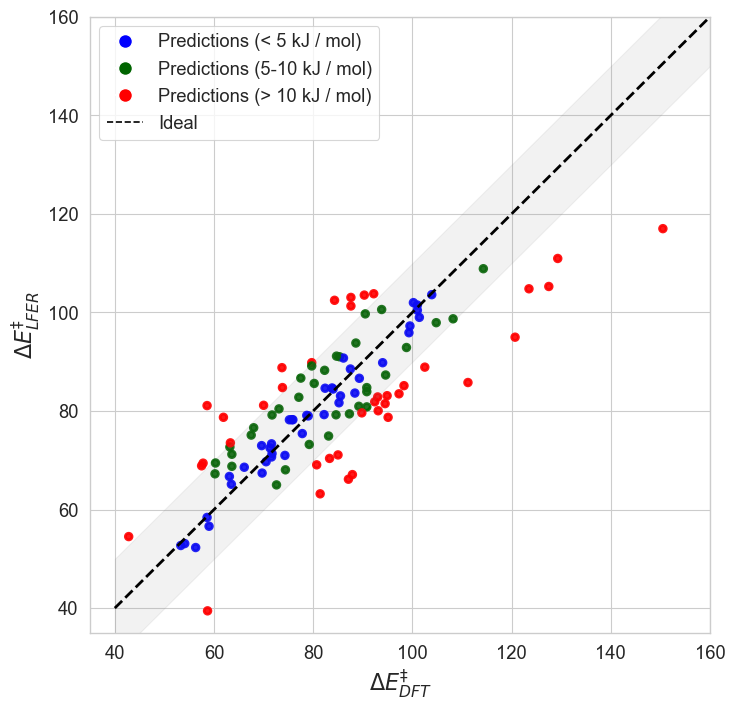

#predictions < 5 40
#predictions < 10 34
#Outliers =  38


In [4]:
#plot
plt.figure(figsize=(8, 8))
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)

plt.xlim(35, 160)
plt.ylim(35, 160)

# colorscheme=['blue']*len(df)
colorscheme = []
n_outlier = 0
region1 = 0
region2 = 0
for index, row in enumerate(df.itertuples(), start=0):
    difference = abs(row.Barrier - predicted_Barrier2[index])
    if difference < 5:
        colorscheme.append('blue')
        region1 += 1
    elif 5 <= difference < 10:
        colorscheme.append('darkgreen')
        region2 += 1
    else:
        colorscheme.append('red')
        n_outlier += 1
        

plt.scatter(df['Barrier'], predicted_Barrier2, alpha=0.9, linewidths=2, color=colorscheme,marker ="o")

plt.plot([40, 160], [40, 160], 'k--', lw=2)
plt.fill_between([40, 160], [50, 170], [30, 150], color='grey', alpha=0.1)
plt.xlabel(r'$\Delta E_{DFT}^{\ddag}$', fontsize=16)
plt.ylabel(r'$\Delta E_{LFER}^{\ddag}$', fontsize=16)
# plt.title(title)
# plt.legend(["Prediction", "Ideal"], frameon=True)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Predictions (< 5 kJ / mol)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='darkgreen', markersize=10, label='Predictions (5-10 kJ / mol)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Predictions (> 10 kJ / mol)'),
    Line2D([0], [0], linestyle='--', color='black', label='Ideal')
]

# Add legend to the plot
plt.legend(handles=legend_elements, frameon=True, loc='best')


plt.savefig('test_parity_plot_lfer.png', dpi=500, bbox_inches='tight')
#plt.grid(True)
plt.show()


print("#predictions < 5", region1)
print("#predictions < 10", region2)
print("#Outliers = ", n_outlier)